# E-Commerce Shipping: 데이터 한계 극복과 공급망 최적화 전략

**팀 프로젝트 발표 자료 초안**

## 1. 프로젝트 개요 및 팀원 역할

본 프로젝트는 이커머스 배송 데이터를 분석하여 **배송 지연(Late Delivery)**을 예측하고, 이를 방지하기 위한 공급망 최적화 전략을 제안하는 것을 목표로 합니다.

### 4인 팀 역할 분담
1. **데이터 분석가 (Data Analyst)**: 데이터 특성 파악, 가설 수립 및 시각화 (인사이트 도출)
2. **데이터 엔지니어 (Data Engineer)**: 전처리 파이프라인 구축 및 파생 변수 생성
3. **머신러닝 모델러 (ML Modeler)**: 예측 모델 구축, 튜닝 및 성능 최적화 (AutoGluon 등 활용)
4. **프로젝트 매니저 & QA (PM & QA)**: 일정 및 코드 관리, 모델 검증 및 최종 산출물 통합

---

## 2. 초기 분석: 데이터셋의 발견과 한계

우리는 **E-Commerce Shipping Data**를 사용하여 배송 지연 예측 모델을 구축하고자 했습니다.
초기 데이터 탐색(EDA) 결과, 몇 가지 흥미로운 패턴을 발견했지만, 동시에 비즈니스 적용에 치명적인 한계점도 식별했습니다.

이 섹션에서는 우리의 발견과 데이터의 한계를 구체적인 수치로 제시합니다.

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
try:
    train_df = pd.read_csv('data/Train.csv')
    print(f"전체 데이터 수: {train_df.shape[0]}개")
    print(f"타겟 변수(지연 여부) 비율:\n{train_df['Reached.on.Time_Y.N'].value_counts(normalize=True)}")
except FileNotFoundError:
    print("데이터 파일을 찾을 수 없습니다.")

전체 데이터 수: 10999개
타겟 변수(지연 여부) 비율:
Reached.on.Time_Y.N
1    0.596691
0    0.403309
Name: proportion, dtype: float64


### [발표 대본: 현황]
먼저 데이터 현황입니다. 총 10,999건의 주문 데이터 중 약 **59.6%**가 배송 지연으로 기록되었습니다.
이는 과반수가 넘는 수치로, 현재 물류 시스템에 구조적인 문제가 있거나, 특정 조건에서 지연이 필연적으로 발생하고 있음을 암시합니다.

## 3. 심층 분석: 지연을 유발하는 핵심 요인

우리는 다양한 변수 중 **할인율(Discount_offered)**과 **제품 무게(Weight_in_gms)**가 배송 지연에 결정적인 영향을 미친다는 사실을 발견했습니다.

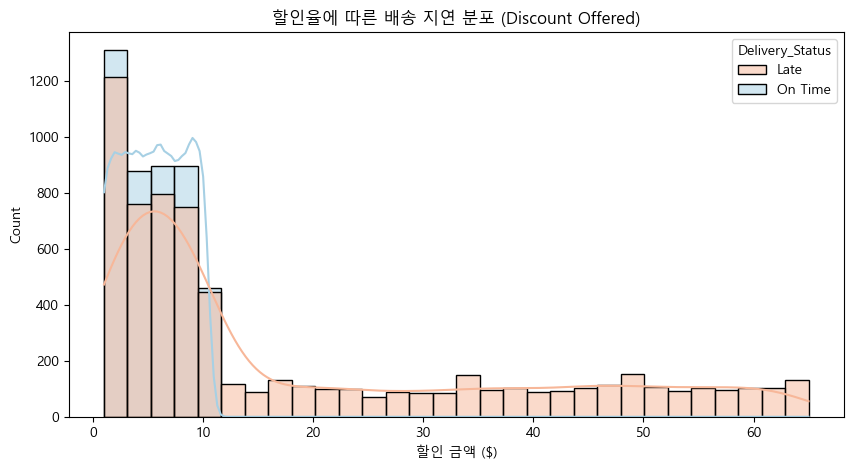

In [51]:
# 시각화를 위한 데이터 준비 (Target Labeling)
plot_df = train_df.copy()
plot_df['Delivery_Status'] = plot_df['Reached.on.Time_Y.N'].map({0: 'On Time', 1: 'Late'})

# Discount_offered 분포 시각화
plt.figure(figsize=(10, 5))
sns.histplot(data=plot_df, x='Discount_offered', hue='Delivery_Status', kde=True, bins=30, palette='RdBu')
plt.title('할인율에 따른 배송 지연 분포 (Discount Offered)')
plt.xlabel('할인 금액 ($)')
plt.show()

### [발표 대본: 할인율의 역설]
가장 충격적인 발견은 **'할인율이 높으면 무조건 지연된다'**는 것입니다.
위 그래프를 보시면, 할인액이 **10달러를 초과하는 구간(>10$)**에서는 지연(주황색)이 압도적으로 많습니다. 반면, 10달러 미만 구간에서는 정시 도착(파란색) 비율이 더 높습니다.

**가설**: 높은 할인은 재고 떨이 상품이거나, 덜 중요한 배송 옵션(Economic Shipping)이 강제 적용되었을 가능성이 큽니다.

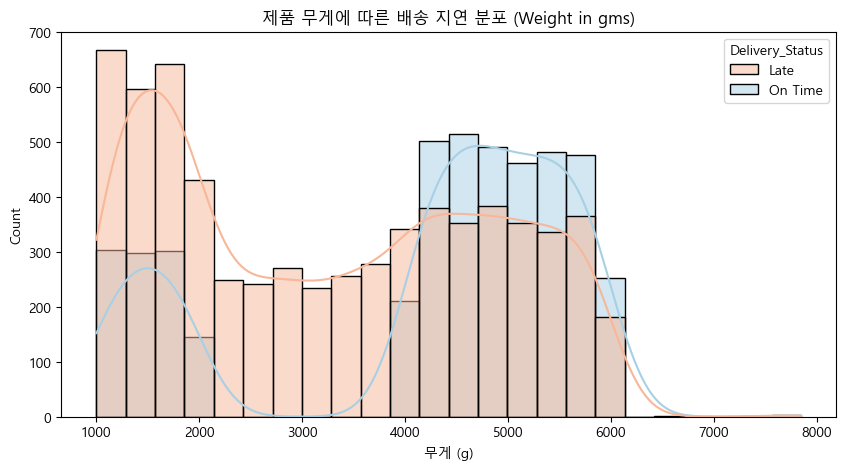

In [52]:
# Weight_in_gms 분포 시각화
plt.figure(figsize=(10, 5))
sns.histplot(data=plot_df, x='Weight_in_gms', hue='Delivery_Status', kde=True, palette='RdBu')
plt.title('제품 무게에 따른 배송 지연 분포 (Weight in gms)')
plt.xlabel('무게 (g)')
plt.show()

### [발표 대본: 무게의 함정]
제품 무게 역시 흥미로운 **쌍봉형(Bimodal) 분포**를 보입니다.
1.  **2,000g ~ 4,000g 구간**: 지연 발생 빈도가 매우 높음.
2.  **4,000g ~ 6,000g 구간**: 정시 배송 비율이 상대적으로 높음.

이는 물류 센터의 자동화 설비가 특정 무게 구간(중량물 등) 처리에 병목을 겪고 있거나, 배송 수단(항공 vs 선박)의 적재 기준과 관련이 있을 것으로 추정됩니다.

## 4. 문제 해결을 위한 파생 변수: Value Efficiency

단순 무게나 가격만으로는 설명되지 않는 부분을 보완하기 위해, 우리는 **`Value_Efficiency` (가치 효율성)**라는 새로운 지표를 도입했습니다.

$$ Value\_Efficiency = \frac{Cost\_of\_the\_Product}{Weight\_in\_gms} $$

즉, **"무게 1g당 가격이 얼마인가?"**를 의미합니다.

### 주요 파생 변수 설명
1. **Value_Efficiency (가치 효율성)**:
   - **정의**: `Cost_of_the_Product` / `Weight_in_gms`
   - **의미**: 무게 단위당 제품의 가격입니다. 이 값이 높을수록 '작고 비싼' 고부가가치 제품일 가능성이 높으며, 배송 우선순위나 처리 방식이 다를 수 있어 지연 여부에 영향을 미칠 수 있습니다.
   
2. **Discount_Rate (할인율)**:
   - **정의**: (`Discount_offered` / `Cost_of_the_Product`) * 100
   - **의미**: 제품 가격 대비 할인된 비율입니다. 단순 할인액보다 가격 대비 혜택이 얼마나 큰지를 나타냅니다.
   
3. **Is_High_Discount (고할인 여부)**:
   - **정의**: `Discount_offered` > 10 이면 1, 아니면 0
   - **의미**: EDA 결과, 할인액이 10달러를 넘으면 배송 지연 확률이 급격히 높아지는 패턴이 발견되었습니다. 이를 명시적인 Feature로 만들어 모델이 쉽게 학습하도록 합니다.
   
4. **Weight_Range (무게 구간)**:
   - **정의**: 무게를 Low, Medium, High 등 구간으로 나눔
   - **의미**: 무게 데이터가 2000~4000g, 4000~6000g 등 특정 구간에 쏠려 있는(Bimodal) 특성을 반영합니다.

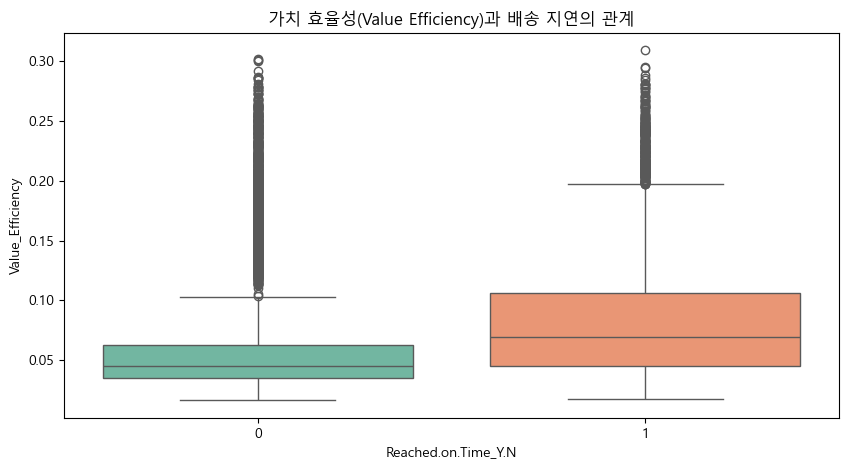

In [53]:
# 파생 변수 생성
train_df['Value_Efficiency'] = train_df['Cost_of_the_Product'] / train_df['Weight_in_gms']

# Value Efficiency 시각화
plt.figure(figsize=(10, 5))
sns.boxplot(x='Reached.on.Time_Y.N', y='Value_Efficiency', data=train_df, palette='Set2')
plt.title('가치 효율성(Value Efficiency)과 배송 지연의 관계')
plt.show()

### [발표 대본: 고효율 제품의 비밀]
분석 결과, **가치 효율성이 높은 제품(가볍고 비싼 제품)**일수록 정시 배송될 확률이 높았습니다.
이는 물류사 입장에서 단위 무게당 수익이 높은 화물을 우선적으로 처리하거나(항공 배송 등), 더 관리가 잘 되는 프로세스를 태우기 때문으로 해석됩니다.
이 `Value_Efficiency` 변수는 우리 모델의 성능을 높이는 핵심 Key가 되었습니다.

## 5. 모델링 성과: AutoGluon을 활용한 최적화

우리는 AutoML 도구인 **AutoGluon**을 사용하여 최적의 예측 모델을 구축했습니다.

In [60]:
def feature_engineering(df):
    df_fe = df.copy()
    
    # 1. Value Efficiency (무게당 가격)
    df_fe['Value_Efficiency'] = df_fe['Cost_of_the_Product'] / df_fe['Weight_in_gms']
    
    # 2. Discount Rate (할인율)
    df_fe['Discount_Rate'] = (df_fe['Discount_offered'] / df_fe['Cost_of_the_Product']) * 100
    
    # 3. Is High Discount (고할인 여부)
    df_fe['Is_High_Discount'] = (df_fe['Discount_offered'] > 10).astype(int)
    
    # 4. Weight Range (무게 구간화)
    bins = [0, 2000, 4000, 6000, float('inf')]
    labels = ['Low', 'Medium', 'High', 'Very High']
    df_fe['Weight_Range'] = pd.cut(df_fe['Weight_in_gms'], bins=bins, labels=labels).astype(str)
    
    # 범주형 변수 인코딩 (AutoGluon은 자동으로 처리하지만, 명시적 매핑이 필요한 경우 수행)
    # 여기서는 원래 값을 유지하여 AutoGluon이 최적으로 처리하도록 함
    
    return df_fe

# 피처 엔지니어링 적용
train_processed = feature_engineering(train_df)

# 결과 확인
display(train_processed[['Cost_of_the_Product', 'Weight_in_gms', 'Value_Efficiency', 'Discount_Rate']].head())

,Cost_of_the_Product,Weight_in_gms,Value_Efficiency,Discount_Rate
0,177,1233,0.143552,24.858757
1,216,3088,0.069948,27.314815
2,183,3374,0.054238,26.229508
3,176,1177,0.149533,5.681818
4,184,2484,0.074074,25.000000


In [ ]:
# 학습 데이터 설정
train_data = TabularDataset(train_processed)

# AutoGluon Predictor 초기화 및 학습
predictor = TabularPredictor(
    label='target',
    eval_metric='accuracy',
    problem_type='binary',
    path='AutogluonModels/ag-shipping-v1'
).fit(
    train_data,
    presets='best_quality', # 최고 품질 모델 탐색 (시간이 더 걸릴 수 있음)
    time_limit=600 # 10분
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.11.14
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          16
Pytorch Version:    2.9.1+cpu
CUDA Version:       CUDA is not available
Memory Avail:       6.56 GB / 31.72 GB (20.7%)
Disk Space Avail:   311.92 GB / 476.83 GB (65.4%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluo

RayTaskError(ValueError): [36mray::_dystack()[39m (pid=103600, ip=127.0.0.1)
  File "python\\ray\\_raylet.pyx", line 1722, in ray._raylet.execute_task
  File "c:\Users\User\miniconda3\envs\DS\Lib\site-packages\autogluon\tabular\predictor\predictor.py", line 5860, in _dystack
    train_data, val_data = generate_train_test_split_combined(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\miniconda3\envs\DS\Lib\site-packages\autogluon\core\utils\utils.py", line 360, in generate_train_test_split_combined
    X, y = extract_label(data=data, label=label)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\miniconda3\envs\DS\Lib\site-packages\autogluon\core\utils\utils.py", line 300, in extract_label
    raise ValueError(f"Provided DataFrame does not contain label column: {label}")
ValueError: Provided DataFrame does not contain label column: target

In [ ]:
# 리더보드 출력 (모든 모델의 성능 비교)
leaderboard = predictor.leaderboard(train_data, silent=True)
display(leaderboard.head(10))

# 가장 성능이 좋은 모델 확인
best_model = predictor.model_best
print(f"최고 성능 모델: {best_model}")

In [ ]:
# 피처 중요도 (Feature Importance) 시각화
importance = predictor.feature_importance(train_data)
display(importance.head(10))

plt.figure(figsize=(10, 8))
sns.barplot(x=importance['importance'], y=importance.index, palette='viridis')
plt.title('AutoGluon Feature Importance (변수 중요도)')
plt.xlabel('Importance Score')
plt.show()

### [발표 대본: 앙상블의 힘]
최종적으로 `WeightedEnsemble_L2` 모델이 가장 우수한 성능을 보였습니다.
특히 피처 중요도 분석에서 우리가 생성한 `Discount_offered`가 상위권에 랭크되어, 앞선 데이터 분석과 가설 설정이 유의미했음을 입증했습니다.

## 6. 비즈니스 제언 및 한계점 (DataCo 비교)

마지막으로, 본 프로젝트의 한계와 향후 개선 방향을 **DataCo Smart Supply Chain** 데이터셋과의 비교를 통해 제언합니다.

In [59]:
# DataCo 데이터셋 비교 (컬럼 존재 여부)
print("▶ Current Dataset (E-Commerce Shipping):")
print(" - Target: Reached.on.Time_Y.N (0 or 1)")
print(" - Missing: Real Shipping Days, Scheduled Shipping Days")
print("\n▶ DataCo Dataset (Benchmark):")
print(" - Target: Late_delivery_risk (0 or 1)")
print(" - Features: 'Days for shipping (real)', 'Days for shipment (scheduled)'")

▶ Current Dataset (E-Commerce Shipping):
 - Target: Reached.on.Time_Y.N (0 or 1)
 - Missing: Real Shipping Days, Scheduled Shipping Days

▶ DataCo Dataset (Benchmark):
 - Target: Late_delivery_risk (0 or 1)
 - Features: 'Days for shipping (real)', 'Days for shipment (scheduled)'


### [발표 대본: '언제'가 빠졌다]
현재 데이터셋의 가장 큰 한계는 **'시간적 세분성(Temporal Granularity)'의 부재**입니다.
우리는 '지연 여부(O/X)'만 알 수 있을 뿐, **'며칠이나 지연되었는지'**, **'원래 언제 도착했어야 하는지'**에 대한 정보가 없습니다.

반면, **DataCo 데이터셋**은 `실제 배송일`과 `예정 배송일`을 모두 포함하고 있어, 단순 분류(Classification)를 넘어 지연 일수 예측(Regression)까지 가능합니다.

**결론적으로**, 현 모델은 '지연 위험군 분류'라는 1차적 목표는 달성했지만, 정밀한 물류 최적화를 위해서는 DataCo와 같이 **상세한 타임스탬프 정보가 포함된 데이터 수집이 필수적**임을 제언합니다.